In [1]:
#http://qiita.com/chachay/items/052406176c55dd5b9a6a

In [45]:
%matplotlib inline
import numpy as np

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import report, training, Chain, datasets, iterators, optimizers
from chainer.training import extensions
from chainer.datasets import tuple_dataset

import matplotlib.pyplot as plt

In [46]:
class MLP(Chain):
    n_input  = 1
    n_output = 1
    n_units  = 5

    def __init__(self):
        super(MLP, self).__init__(
            l1 = L.Linear(self.n_input, self.n_units),
            l2 = L.LSTM(self.n_units, self.n_units),
            l3 = L.Linear(self.n_units, self.n_output),
        )

    def reset_state(self):
        self.l2.reset_state()

    def __call__(self, x):
        h1 = self.l1(x)
        h2 = self.l2(h1)
        return self.l3(h2)

In [47]:
class LossFuncL(Chain):
    def __init__(self, predictor):
        super(LossFuncL, self).__init__(predictor=predictor)

    def __call__(self, x, t):
#         x.data = x.data.reshape((-1, 1)).astype(np.float32)
#         t.data = t.data.reshape((-1, 1)).astype(np.float32)

        y = self.predictor(x)
        loss = F.mean_squared_error(y, t)
        report({'loss':loss}, self)
        return loss


In [48]:
model = LossFuncL(MLP())
optimizer = optimizers.Adam()
optimizer.setup(model)

In [49]:
class LSTM_test_Iterator(chainer.dataset.Iterator):
    def __init__(self, dataset, batch_size = 10, seq_len = 5, repeat = True):
        self.seq_length = seq_len
        self.dataset = dataset
        self.nsamples =  len(dataset)

        self.batch_size = batch_size
        self.repeat = repeat

        self.epoch = 0
        self.iteration = 0
        self.offsets = np.random.randint(0, len(dataset),size=batch_size)

        self.is_new_epoch = False

    def __next__(self):
        if not self.repeat and self.iteration * self.batch_size >= self.nsamples:
            raise StopIteration

        x, t = self.get_data()
        self.iteration += 1

        epoch = self.iteration // self.batch_size
        self.is_new_epoch = self.epoch < epoch
        if self.is_new_epoch:
            self.epoch = epoch
            self.offsets = np.random.randint(0, self.nsamples,size=self.batch_size)

        return list(zip(x, t))

    @property
    def epoch_detail(self):
        return self.iteration * self.batch_size / len(self.dataset)

    def get_data(self):
        tmp0 = [self.dataset[(offset + self.iteration)%self.nsamples][0]
               for offset in self.offsets]
        tmp1 = [self.dataset[(offset + self.iteration + 1)%self.nsamples][0]
               for offset in self.offsets]
        return tmp0,tmp1

    def serialzie(self, serialzier):
        self.iteration = serializer('iteration', self.iteration)
        self.epoch     = serializer('epoch', self.epoch)

class LSTM_updater(training.StandardUpdater):
    def __init__(self, train_iter, optimizer, device):
        super(LSTM_updater, self).__init__(train_iter, optimizer, device=device)
        self.seq_length = train_iter.seq_length

    def update_core(self):
        loss = 0

        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')

        for i in range(self.seq_length):
            batch = np.array(train_iter.__next__()).astype(np.float32)
#             x, t  = batch[:,0].reshape((-1,1)), batch[:,1].reshape((-1,1))
            x, t  = batch[:,0], batch[:,1]
            loss += optimizer.target(chainer.Variable(x), chainer.Variable(t))

        optimizer.target.zerograds()
        loss.backward()
        loss.unchain_backward()
        optimizer.update()

In [50]:
# データ作成
N_data  = 100
N_Loop  = 3
t = np.linspace(0., 2*np.pi*N_Loop, num=N_data)

X = 0.8*np.sin(2.0*t)

# データセット
N_train = int(N_data*0.8)
N_test  = int(N_data*0.2)

tmp_DataSet_X= np.array(X).astype(np.float32)

x_train, x_test = np.array(tmp_DataSet_X[:N_train]),np.array(tmp_DataSet_X[N_train:])

#add
x_train = x_train.reshape((-1, 1)).astype(np.float32)
x_test = x_test.reshape((-1, 1)).astype(np.float32)

train = tuple_dataset.TupleDataset(x_train)
test  = tuple_dataset.TupleDataset(x_test)

In [51]:
train_iter = LSTM_test_Iterator(train, batch_size = 10, seq_len = 10)
test_iter  = LSTM_test_Iterator(test,  batch_size = 10, seq_len = 10, repeat = False)

In [52]:
updater = LSTM_updater(train_iter, optimizer, -1)
trainer = training.Trainer(updater, (1000, 'epoch'), out = 'result')

eval_model = model.copy()
eval_rnn = eval_model.predictor
eval_rnn.train = False
trainer.extend(extensions.Evaluator(
        test_iter, eval_model, device=-1,
        eval_hook=lambda _: eval_rnn.reset_state()))

trainer.extend(extensions.LogReport())

trainer.extend(
        extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss']
            )
        )

trainer.extend(extensions.ProgressBar())

In [53]:
trainer.run()

epoch       main/loss   validation/main/loss
1           0.437808    0.370571              
2           0.468358    0.36855               
3           0.266945    0.36659               
4           0.451415    0.364819              
5           0.255151    0.362972              
6           0.183436    0.361033              
7           0.29553     0.359201              
8           0.384093    0.357372              
9           0.339314    0.355539              
10          0.250767    0.353745              
11          0.378178    0.351937              
12          0.303508    0.350121              
13          0.378593    0.348392              
14          0.414131    0.346662              
15          0.327876    0.344874              
16          0.262886    0.343041              
17          0.404521    0.341238              
18          0.289459    0.339478              
19          0.417773    0.337785              
20          0.346659    0.33607               
21          0.3

163         0.0939468   0.175526              
164         0.0811912   0.174898              
165         0.0893699   0.174281              
166         0.089754    0.173669              
167         0.0572115   0.173043              
168         0.0743574   0.172467              
169         0.0769901   0.171847              
170         0.0700695   0.171268              
171         0.118298    0.170661              
172         0.0904134   0.170084              
173         0.0643737   0.169506              
174         0.0767503   0.1689                
175         0.107369    0.168254              
176         0.0608067   0.167545              
177         0.0598405   0.166897              
178         0.06513     0.166198              
179         0.056489    0.165509              
180         0.0581569   0.164946              
181         0.0685029   0.164464              
182         0.0734294   0.16398               
183         0.0771885   0.163384              
184         0

317         0.00590083  0.100366              
318         0.00764777  0.100079              
319         0.0415144   0.0997857             
320         0.0101389   0.099506              
321         0.00575509  0.0992381             
322         0.00516436  0.0990049             
323         0.00341819  0.0987139             
324         0.00637858  0.098432              
325         0.00843462  0.0981606             
326         0.00282315  0.0979111             
327         0.00515327  0.0975564             
328         0.00587075  0.0970794             
329         0.00523343  0.0966605             
330         0.00512973  0.096275              
331         0.0443064   0.0959204             
332         0.00934039  0.0956687             
333         0.00346296  0.0953648             
334         0.00480986  0.09506               
335         0.00513558  0.0947473             
336         0.0415572   0.0944439             
337         0.00466465  0.0942198             
338         0

477         0.00498166  0.070539              
478         0.00476477  0.0703251             
479         0.00363515  0.0701429             
480         0.00106046  0.0699495             
481         0.0018071   0.0697529             
482         0.00110557  0.0695369             
483         0.00550764  0.0693783             
484         0.00271608  0.0692435             
485         0.00299583  0.0691004             
486         0.0058039   0.0689268             
487         0.00163377  0.0687004             
488         0.00592894  0.0684986             
489         0.0385506   0.068245              
490         0.00582376  0.06801               
491         0.0366604   0.0677594             
492         0.00145452  0.0675633             
493         0.037522    0.0673768             
494         0.00241826  0.0671814             
495         0.00306838  0.0669586             
496         0.0031049   0.0667323             
497         0.00529867  0.0664968             
498         0

631         0.0019214   0.0586744             
632         0.00399788  0.0586251             
633         0.00400727  0.0585499             
634         0.00755975  0.0584367             
635         0.00414686  0.058305              
636         0.00438652  0.0581388             
637         0.00382641  0.0579265             
638         0.00408759  0.0577184             
639         0.00461129  0.0575152             
640         0.00243954  0.0573379             
641         0.00390831  0.0571972             
642         0.00350319  0.0571                
643         0.00540404  0.057048              
644         0.00462963  0.05701               
645         0.00759185  0.0570006             
646         0.00430793  0.0570647             
647         0.00421886  0.0571458             
648         0.00448729  0.0572357             
649         0.0369755   0.0572928             
650         0.0387822   0.0573338             
651         0.00213805  0.057376              
652         0

794         0.00365256  0.0544424             
795         0.039214    0.0543414             
796         0.00190016  0.0542373             
797         0.00365172  0.0541454             
798         0.00127063  0.0540194             
799         0.0350254   0.0538889             
800         0.00383683  0.0537686             
     total [##################################################] 100.00%
this epoch [..................................................]  0.00%
       800 iter, 800 epoch / 1000 epochs
    30.332 iters/sec. Estimated time to finish: 0:00:00.


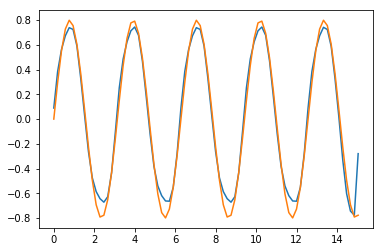

In [54]:
presteps = 10
model.predictor.reset_state()

for i in range(presteps):
    y = model.predictor(chainer.Variable(np.roll(x_train,i).reshape((-1,1))))

plt.plot(t[:N_train],np.roll(y.data,-presteps))
plt.plot(t[:N_train],x_train)
plt.show() 

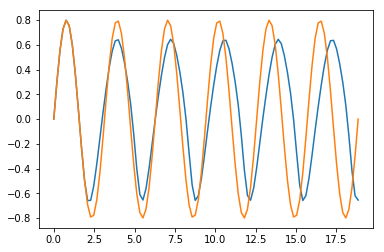

In [55]:
presteps = int(N_data*0.1)
poststeps = N_data - presteps
model.predictor.reset_state()

y_result = []

for i in range(presteps):
    y = model.predictor(chainer.Variable(x_train[i].reshape((-1,1))))
    y_result.append(x_train[i])

y_result.append(x_train[presteps])

for i in range(poststeps-1):
    y = model.predictor(chainer.Variable(y.data))
    y_result.append(y.data)

plt.plot(t, y_result)
plt.plot(t, X)
plt.show() 
